# Project: 가위바위보 분류기
[링크](https://teachablemachine.withgoogle.com/train)에서 직접 데이터셋을 생성하여 가위바위보를 분류한다

## 1. 데이터셋 준비

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def resize_images(img_path):
    formats = ["jpg", "png"]
    n_images = 0
    for f in formats:
        images=glob.glob(img_path + f"/*.{f}")  
        n_images += len(images)
        

        # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
        target_size=(28,28)
        for img in images:
            old_img=Image.open(img)
            new_img=old_img.resize(target_size,Image.ANTIALIAS)
            new_img.save(img, "JPEG")
    print(n_images, " images resized.")

for i in ["rock", "scissor", "paper"]:
    image_dir_path = os.getenv("HOME") + f"/aiffel/rock_scissor_paper/{i}"
    resize_images(image_dir_path)


1222  images resized.
1222  images resized.
1222  images resized.


In [3]:
# 데이터 라벨링
def load_data(img_path, number_of_data=3366):  # 가위바위보 이미지 개수 총합에 주의할 것!
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (3366, 28, 28, 3)
y_train shape: (3366,)


In [4]:
# test set 만들기
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
for i in ["rock", "scissor", "paper"]:
    resize_images(image_dir_path +"/" + i)

(x_test, y_test)=load_data(image_dir_path, 300)

100  images resized.
100  images resized.
100  images resized.


In [5]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                            rotation_range=20, zoom_range=0.2,
                            width_shift_range=0.2, height_shift_range=0.2,
                            shear_range=0.1, fill_mode="nearest", rescale=1./255)
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(x_train)
testgen.fit(x_test)

## 2. 모델 설계

In [31]:
n_channel_1=32
n_channel_2=64
n_channel_3=64
n_dense=128
n_train_epoch=25

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (5,5), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)             

## 3. 모델 학습

In [32]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


history = model.fit(datagen.flow(x_train, y_train, batch_size=16), epochs=n_train_epoch)

Epoch 1/25
211/211 [==============================] - 2s 9ms/step - loss: 0.5393 - accuracy: 0.7002
Epoch 2/25
211/211 [==============================] - 2s 8ms/step - loss: 0.4914 - accuracy: 0.7335
Epoch 3/25
211/211 [==============================] - 2s 8ms/step - loss: 0.4730 - accuracy: 0.7585
Epoch 4/25
211/211 [==============================] - 2s 8ms/step - loss: 0.4455 - accuracy: 0.7837
Epoch 5/25
211/211 [==============================] - 2s 8ms/step - loss: 0.4232 - accuracy: 0.7941
Epoch 6/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3900 - accuracy: 0.8182
Epoch 7/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3799 - accuracy: 0.8247
Epoch 8/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3528 - accuracy: 0.8381
Epoch 9/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3479 - accuracy: 0.8461
Epoch 10/25
211/211 [==============================] - 2s 8ms/step - loss: 0.3232 - accuracy: 0.8583

## 4. 모델 평가

In [33]:
test_loss, test_accuracy = model.evaluate(testgen.flow(x_test, y_test, batch_size=32), verbose=2)
print(f"test_loss: {test_loss} ")
print(f"test_accuracy: {test_accuracy}") 

10/10 - 0s - loss: 0.8389 - accuracy: 0.6800
test_loss: 0.8388828039169312 
test_accuracy: 0.6800000071525574


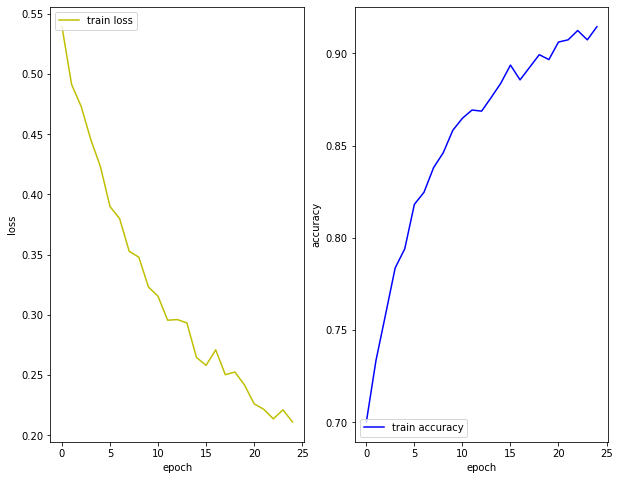

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(history.history['loss'], 'y', label = 'train loss')

ax[1].plot(history.history['accuracy'], 'b', label = 'train accuracy')

ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

ax[0].legend(loc='upper left')
ax[1].legend(loc='lower left')

plt.show()

## 회고

- 처음 클래스 별 100장의 데이터만 사용했을 때는 학습이 되지 않았다.
- 데이터를 추가하고, `tensorflow.keras.preprocessing.image` 의 `ImageDataGeneratoraugmentation`을 사용하여 augmentation도 해주었다. 
- MNIST와 다르게 RGB 채널로 되어있고, 다양한 환경에서 제작된 데이터를 가져와서 채널 수를 많이 주면 더 학습이 잘될 것이라고 예측했지만, 오히려 채널 수를 너무 늘리면 정확도가 떨어졌다. 그래서 적절한 값을 찾기 위해 고군분투하였다.
- 오버피팅 방지를 위해 BatchNormalization을 추가하였다.
- Dropout 등의 다른 오버피팅 방지 기법을 사용해봐도 좋을 것 같다.
- Valid set을 만들어서 early stopping이나, learning rate scheduler를 사용하는 것도 좋은 방법일 것 같다.
- 수업 하나를 제외하고 나머지 수업, 그리고 프로젝트에서 모두 `pytorch`를 사용해서 `keras`를 오랜만에 사용하는 것이 어색했지만, 그래도 기본적인 모델 구축은 어렵지 않게 할 수 있었다.
